### Qiskit Implementierung: Grovers Algorithmus mit zwei Qubits
In diesem Beispiel werden zwei Qubits genutzt, um den Zustand $|11\rangle$ zu finden.

Zuerst muss dazu die Umgebung initialisiert werden.

In [1]:
#Initialisierung zum Plotten und Numpy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Importieren der relevanten Qiskit Module
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# Importieren von Visualierungen
from qiskit.tools.visualization import plot_histogram

Als erstes sollen Sie ein Orakel definieren, dass den Zustand $|11\rangle$ markiert. Dazu sollen sie eine Funktion Orakel definieren, welche als Argumente den Schaltkreis und das Quantenregister hat. In dem Orakel müssen sie ein Gatter anwenden, dass die Phase des Zustandes nur dann ändert, wenn der Zustand $|11\rangle$ ist.
Erstellen sie dann ein `QuantumRegister` mit zwei Qubits, den Orakelschaltkreis, der auf das Quantenregister angewendet wird und führen sie ihre Funktion aus. Lassen Sie sich den Schaltkreis anzeigen. 

Lösung: wir brauchen ein kontrolliertes $Z$-Gatter: $$CZ=\left(\begin{array}{cccc} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1\end{array}\right)$$
Dies kann in Qiskit direkt (mit 'cz') verwendet werden, oder aus dem CNOT- (d.h. $CX$-) Gatter konstruiert werden, indem man dieses mittels $HXH=Z$ in ein $CZ$-Gatter verwandelt.

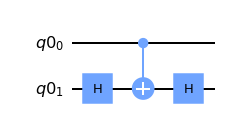

In [2]:
def Orakel(circuit, register):
    # Schreiben Sie hier ihren Code. Mit "register[0]" bzw. "register[1]"
    # können Sie die beiden Qubits ansprechen, z.B.
    # circuit.h(register[1])
    # wäre ein Hadamard-Gatter für das zweite Qubit. Mit
    # circuit.h(register)
    # würde hingegen ein Hadamard-Gatter auf beide Qubits im Register angewandt.
    
    circuit.h(register[1])
    circuit.cx(register[0],register[1])
    circuit.h(register[1])
    
    #Orakel Ende

# Hauptprogramm, welches Register und Schaltkreis definiert,
# dann die obige Orakelfunktion auruft und den Schaltkreis plottet:  
qr = QuantumRegister(2)
oracleCircuit = QuantumCircuit(qr)
Orakel(oracleCircuit, qr)
oracleCircuit.draw(output="mpl")

Als nächstes erstellen sie den Diffusionsoperator. Erstellen Sie auch für diesen Operator eine Funktion. Nehmen sie als Name Diffusion und als Argumente wieder Schaltkreis und Register.
Denken Sie dabei an die in der Vorlesung auf S. 62 gezeigte Gleichung $D=H^{\otimes n}(2|0\rangle\langle0|-{\mathbb I})H^{\otimes n}$.

Lösung: $$2|0\rangle\langle0|-{\mathbb I}=\left(\begin{array}{cccc} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & -1\end{array}\right)$$
Bis auf eine (irrelevante) globale Phase ist dies äquivalent zu:
$$\left(\begin{array}{cccc} -1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{array}\right)$$
also dasselbe wie oben beim Orakel, nur mit Zustand $|00\rangle$ statt $|11\rangle$. Wir fügen daher am Anfang und am Ende bei beiden Qubits $X$-Gatter hinzu (welche $|11\rangle$ auf $|00\rangle$ abbilden und umgekehrt). Eingerahmt wird dies jeweils von zwei $H$-Gattern.

In [3]:
#Schreiben sie die Definition des Diffusionsoperator hier:
def Diffusion(circuit, register):
    circuit.h(register) #wirkt auf alle Qubits in register
    circuit.x(register)
    circuit.h(register[1])
    circuit.cx(register[0],register[1])
    circuit.h(register[1])
    circuit.x(register)
    circuit.h(register)
    

Erstellen Sie nun wieder einen `QuantumCircuit` , wenden Sie ihre Funktion auf ihn an und lassen den Schaltkreis plotten.

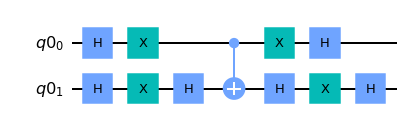

In [4]:
qd = QuantumCircuit(qr)
Diffusion(qd, qr)
qd.draw(output='mpl')

Sie haben jetzt alle Teilstücke des Grover-Algorithmus fertiggestellt. Setzen Sie nun die Einzelteile zusammen. Erstellen sie zuerst ein `QuantumRegister` mit zwei Qubits und ein `ClassicalRegister` mit zwei bits. Konstruieren Sie daraus den `GroverCircuit` und setzen Sie alle Qubits in Superposition.
Anschließen wenden Sie das Orakel und den Diffusor an. Vergessen Sie die Messung nicht! Lassen Sie sich den Schaltkreis zur Kontrolle wieder ausdrucken.

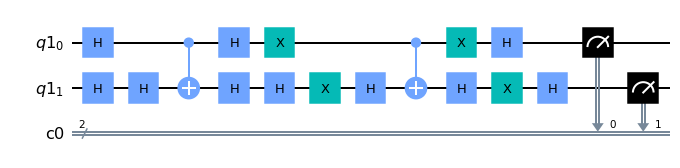

In [5]:
#Schreiben Sie ihren Code hier

qr = QuantumRegister(2)
cr = ClassicalRegister(2)
GroverCircuit = QuantumCircuit(qr,cr)
GroverCircuit.h(qr)
Orakel(GroverCircuit, qr)
Diffusion(GroverCircuit,qr)
GroverCircuit.measure(qr,cr)

GroverCircuit.draw("mpl")

### Messung mit dem Simulator
Nachfolgend soll mit Hilfe des Simulators gemessen werden, ob der richtige Zustand markiert wird.

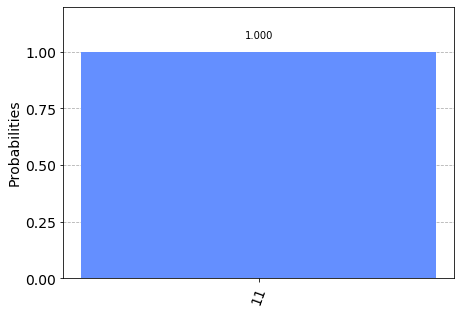

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(GroverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Es sollte zu sehen sein, dass nur der Zustand $|11\rangle$ markiert wurde. (Bei nur zwei Qubits muss der Grover-Operator nicht iteriert werden...)

### Messung an einem realen Quantencopmuter
Um zu sehen, wie eine Messung an einem realen Qunatencomputer aussieht, soll nun auch an so einem gemessen werden. Dazu benötigen Sie einen IBMQ Account und müssen ihren Token gespeichert haben. Mehr Informationen, wo sie ihren Token finden: https://quantum-computing.ibm.com/docs/manage/account/

In [8]:
#IBMQ.save_account('MY_API_TOKEN') #Falls Sie ihren Token noch nicht gespeichert haben, löschen Sie # und fügen Sie
                                    # statt MY_API_TOKEN ihren Token ein
# Um nicht zu lange auf die Ergebnisse warten zu müssen, wird hier das am wenigsten beschäftigte Backend gesucht
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#provider = IBMQ.get_provider(hub='ibm-q-fraunhofer', group='fhg-all', project='ticket') 
backend_lb = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print("Least busy backend: ", backend_lb)

ibmqfactory.load_account:WARNING:2021-01-13 18:25:55,142: Credentials are already in use. The existing account in the session will be replaced.


Least busy backend:  ibmq_boeblingen


In [9]:
# Nun wird der Job auf dem am wenigsten beschäftigten Backend durchgeführt 
# dies kann, je nach Auslastung einige Minuten dauern
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(GroverCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2) #mit dem job_monitor wir der aktuelle Status angezeigt

Job Status: job has successfully run


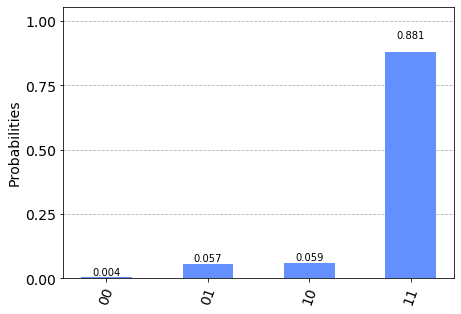

In [10]:
# Hier können Sie das Ergebnis sehen
results = job_exp.result()
answer = results.get_counts(GroverCircuit)
plot_histogram(answer)

### Simulator mit Rauschen
Alternativ mit einem Simulator, in welchem Fehler so eingebaut sind, dass sie denjenigen, die auf dem realen Quantencomputer auftreten, ähneln.
In der Zelle unten wird zunächst das Fehlermodell (noise model) definiert.
(Auf Einzelheiten, wie das Fehlermodell genau funktioniert, können wir hier nicht eingehen...)

In [11]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [12]:
noise_model = get_noise(0.02,0.05) 

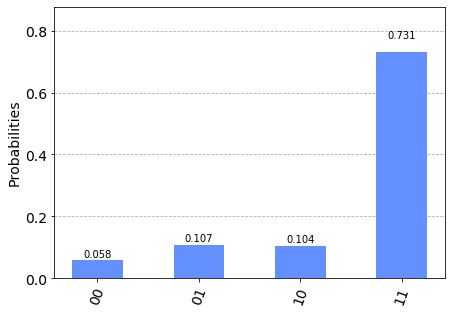

In [13]:
from qiskit import Aer
# run the circuit with th noise model and extract the counts
counts = execute( GroverCircuit, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

## Anzahl der Iterationen
Bisher wurde der Algorithmus nur mit einer Iteration angwendet. Sobald der Algorithmus aber auf eine größere Datenmenge angewendet wird, ist es sinnvoll mehr Iteration zu verwenden, sodass das Ergebnis eindeutig ist. Dies berechnet sich wie folgt (falls $N\gg M$):
$$R\simeq \frac{\pi}{4}\sqrt{\frac{N}{M}}$$
wobei $R$ der Anzahl der Iterationen, $N$ der Anzahl der zu durchsuchenden Elemente und $M$ der Anzahl der Lösungen entspricht.
Berechnen Sie die benötigte Anzahl an Iterationen für $N = 2^4$ Elemente mit einer Lösung ($M=1$) und überprüfen Sie Ihr Ergebnis mit dem nachfolgenden Code, in welchem ein Grover-Schaltkreis für vier Daten-Qubits programmiert ist. Welcher Zustand wird durch das Orakel markiert?

Lösung: $R\simeq \pi=3.14$, also sollte $R=3$ das beste Ergebnis liefern.

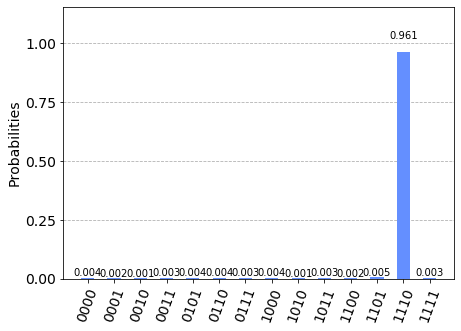

In [20]:
backend = BasicAer.get_backend('qasm_simulator')

database = QuantumRegister(4)
oracle = QuantumRegister(1)
auxiliary = QuantumRegister(2)
cr = ClassicalRegister(4)
qc = QuantumCircuit(database, oracle, auxiliary, cr)
qc.h(database[:])
qc.x(oracle[0])
qc.h(oracle[0])

#Geben Sie hier die Anzahl der Iterationen ein (zunächst auf Null gesetzt):
R=3

for j in range(R):
    # oracle_4q
    qc.x(database[0])
    qc.mct(database[:], oracle[0], auxiliary[:], mode='basic') 
    qc.x(database[0])

    # diffusion_4q
    qc.h(database[:])
    qc.x(database[:])
    qc.h(database[3])
    qc.mct(database[0:3], database[3], auxiliary[:], mode='basic')
    qc.h(database[3])
    qc.x(database[:])
    qc.h(database[:])

qc.h(oracle[0])
qc.x(oracle[0])
qc.measure(database,cr)
    
job = execute(qc, backend=backend, shots=1000)
result = job.result()
count = result.get_counts()
plot_histogram(count)

Markierter Zustand: 1110